In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV untuk beberapa pra-pemrosesan klasik
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
# Konstanta dan Path
BASE_DIR = 'dataset/' # Sesuaikan jika path Anda berbeda
TRAIN_DIR = os.path.join(BASE_DIR, 'train') # Asumsi 'traini' adalah 'train'
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Kelas dari proposal Anda
CLASSES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
NUM_CLASSES = len(CLASSES)
IMG_WIDTH, IMG_HEIGHT = 224, 224 # Ukuran input untuk MobileNetV3
BATCH_SIZE = 32


Menampilkan sampel gambar dari direktori training:


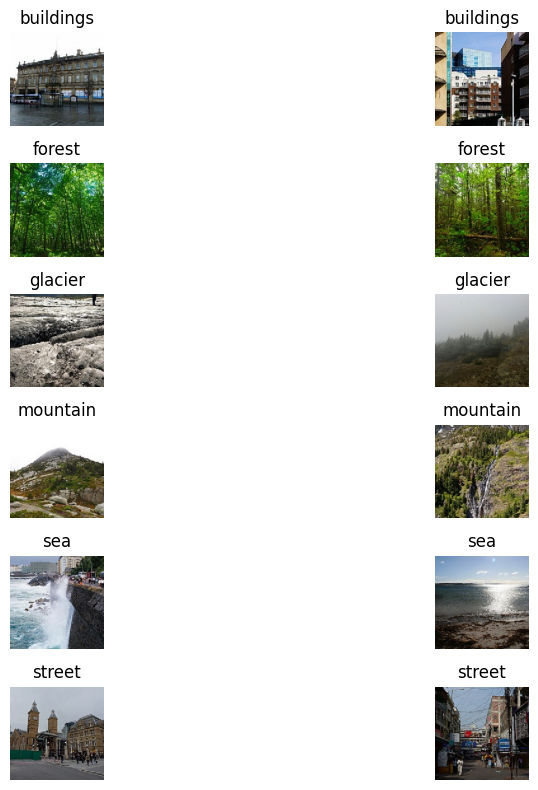

In [7]:
# Fungsi untuk menampilkan sampel gambar
def display_samples(data_dir, num_samples_per_class=2):
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Directory tidak ditemukan - {class_path}")
            continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files:
            print(f"Warning: Tidak ada file gambar di {class_path}")
            continue
            
        for j in range(min(num_samples_per_class, len(image_files))):
            img_path = os.path.join(class_path, np.random.choice(image_files))
            try:
                img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                plt.subplot(NUM_CLASSES, num_samples_per_class, i * num_samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(f"{class_name}")
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("\nMenampilkan sampel gambar dari direktori training:")
display_samples(TRAIN_DIR)


Distribusi Kelas Data Training:


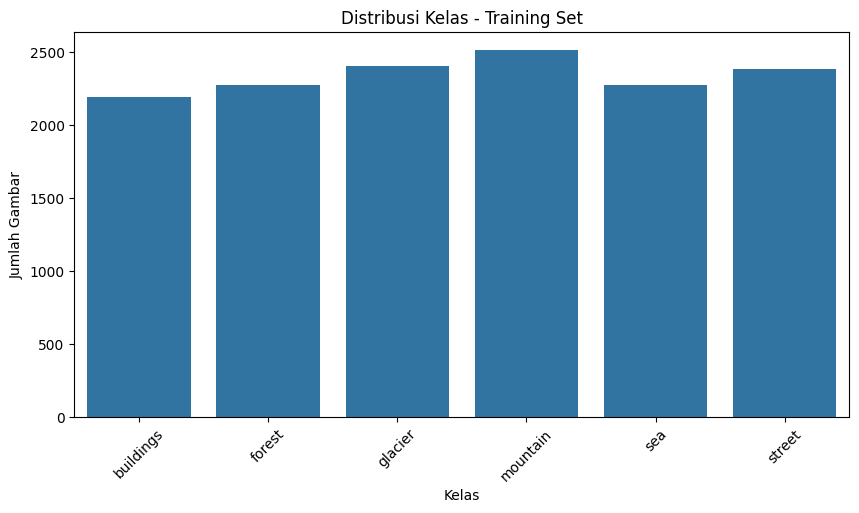

Distribusi kelas untuk Distribusi Kelas - Training Set: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}

Distribusi Kelas Data Testing:


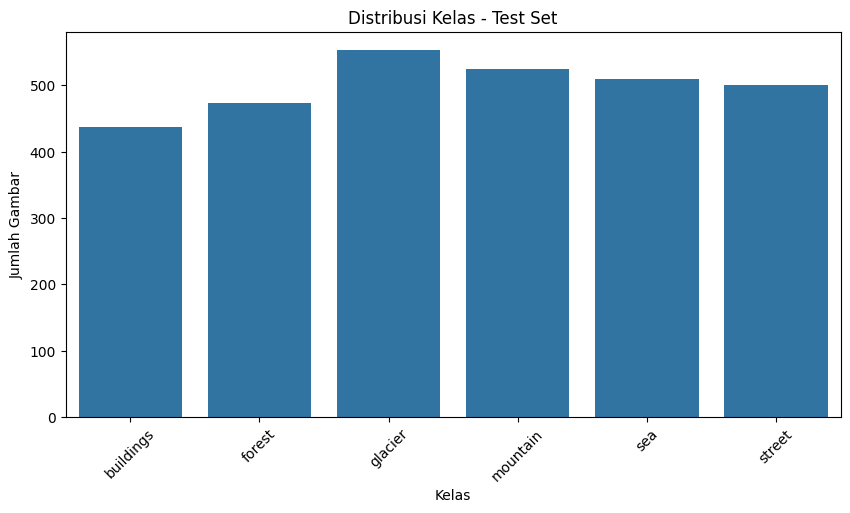

Distribusi kelas untuk Distribusi Kelas - Test Set: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


In [8]:
# Fungsi untuk menghitung dan menampilkan distribusi kelas
def plot_class_distribution(data_dir, title):
    class_counts = {}
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            class_counts[class_name] = 0
            continue
        class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title(title)
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.show()
    print(f"Distribusi kelas untuk {title}: {class_counts}")

print("\nDistribusi Kelas Data Training:")
plot_class_distribution(TRAIN_DIR, "Distribusi Kelas - Training Set")

print("\nDistribusi Kelas Data Testing:")
plot_class_distribution(TEST_DIR, "Distribusi Kelas - Test Set")


Memulai EDA Lanjutan...

Mengumpulkan metadata gambar dari direktori training untuk EDA Lanjutan...
Mengumpulkan metadata dari: dataset/train
  Processing class: buildings (438 sampel)
  Processing class: forest (454 sampel)
  Processing class: glacier (480 sampel)
  Processing class: mountain (502 sampel)
  Processing class: sea (454 sampel)
  Processing class: street (476 sampel)


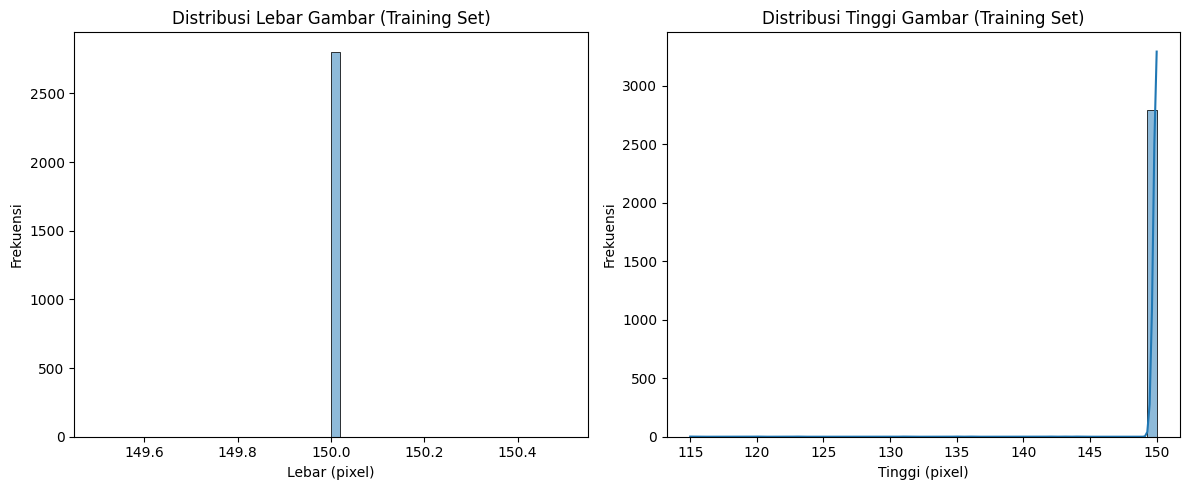


Statistik Deskriptif Dimensi Gambar (Training Set):
Lebar:
 count    2804.0
mean      150.0
std         0.0
min       150.0
25%       150.0
50%       150.0
75%       150.0
max       150.0
Name: width, dtype: float64

Tinggi:
 count    2804.000000
mean      149.942582
std         1.160621
min       115.000000
25%       150.000000
50%       150.000000
75%       150.000000
max       150.000000
Name: height, dtype: float64


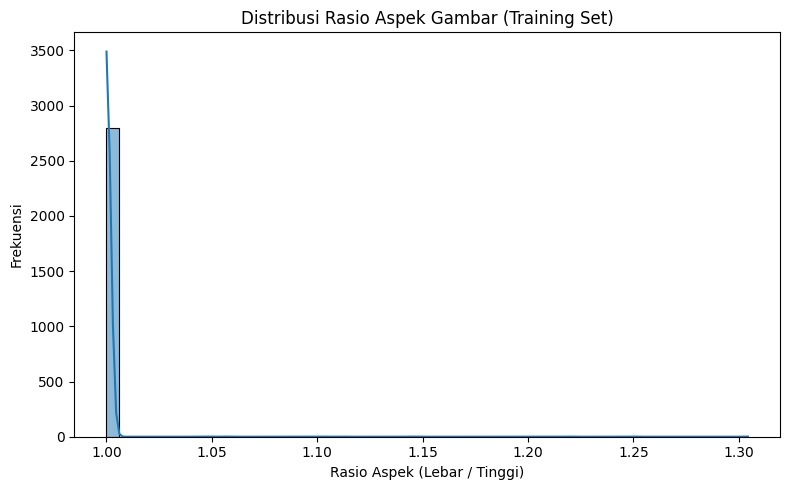


Statistik Deskriptif Rasio Aspek (Training Set):
 count    2804.000000
mean        1.000456
std         0.009520
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.304348
Name: aspect_ratio, dtype: float64


/tmp/ipykernel_3338/1245277937.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Kelas')


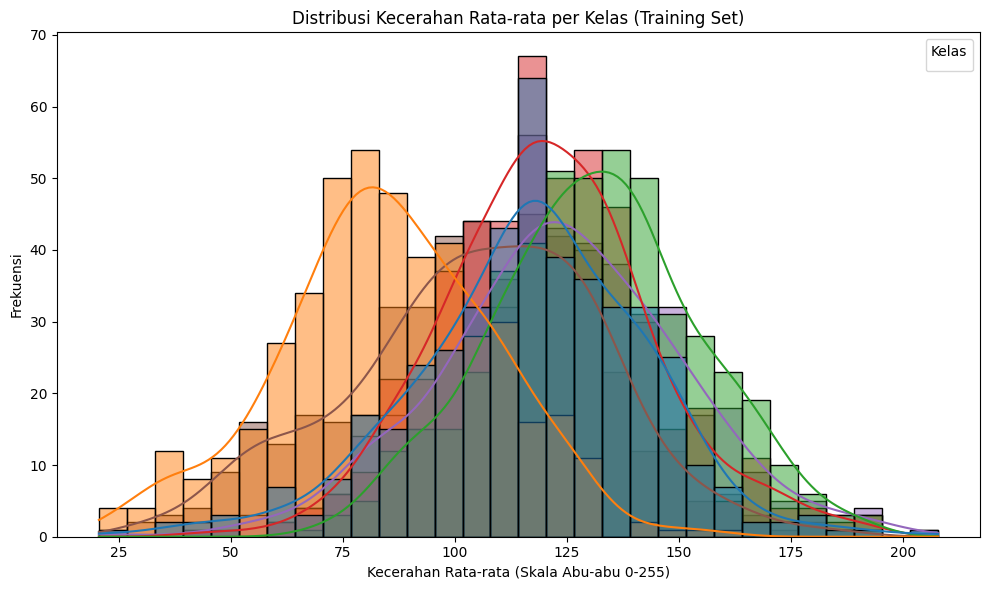

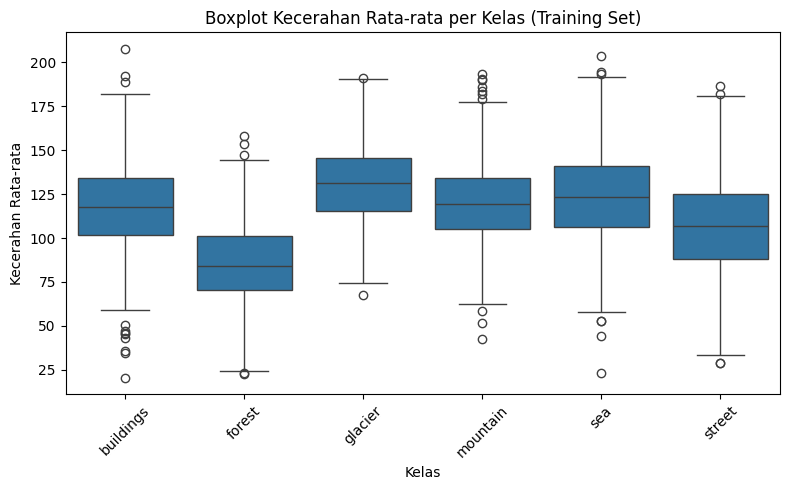


Statistik Deskriptif Kecerahan Rata-rata (Training Set):
 count    2804.000000
mean      113.790910
std        29.419554
min        20.560578
25%        95.019689
50%       115.942600
75%       133.318000
max       207.812311
Name: brightness, dtype: float64

Statistik Deskriptif Kecerahan Rata-rata per Kelas:
           count        mean        std        min         25%         50%  \
class                                                                        
buildings  438.0  116.927704  25.908254  20.560578  101.911900  117.944578   
forest     454.0   84.740618  23.808332  22.533378   70.229922   83.918467   
glacier    480.0  131.064157  23.221433  67.850400  115.673622  131.308533   
mountain   502.0  120.464782  23.451264  42.533600  105.067733  119.580644   
sea        454.0  123.486351  26.922524  22.892844  106.351200  123.547400   
street     476.0  104.908019  28.302454  28.852533   87.844367  106.802156   

                  75%         max  
class                     

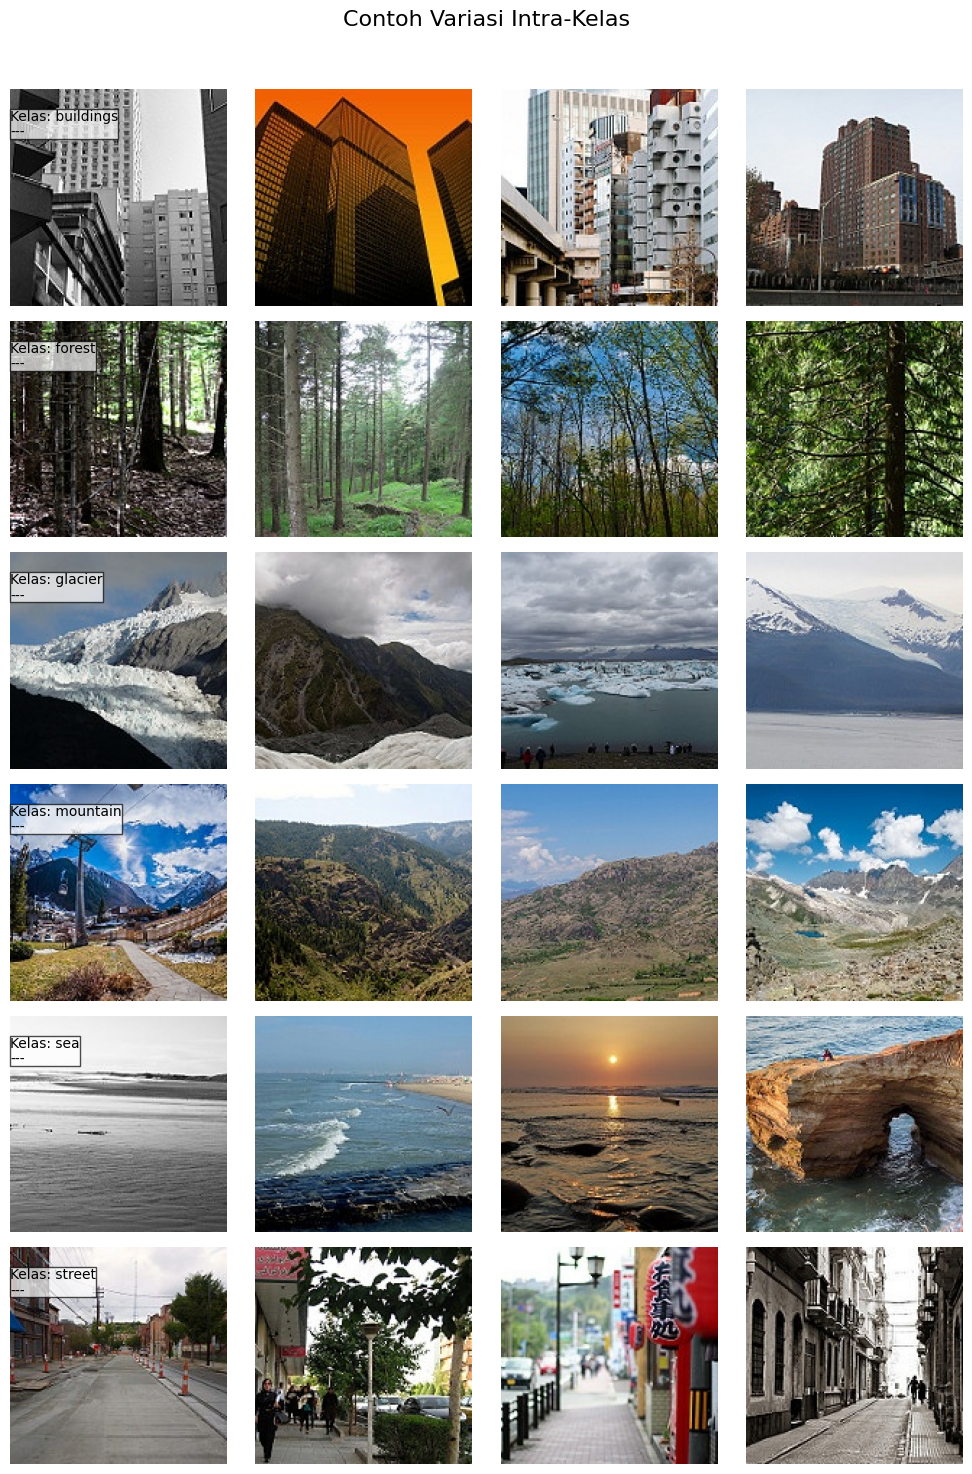


EDA Lanjutan Selesai.


In [9]:
# Lanjutan dari Tahap 1 (setelah kode EDA sebelumnya)
print("\nMemulai EDA Lanjutan...")

import pandas as pd # Untuk mempermudah pengolahan data dimensi

# Fungsi untuk mengumpulkan informasi dimensi dan kecerahan
def get_image_meta_data(data_dir, sample_fraction=0.1): # Ambil sampel untuk efisiensi
    image_metadata = []
    print(f"Mengumpulkan metadata dari: {data_dir}")
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Ambil sampel file jika dataset besar
        if len(image_files) > 100 : # Hanya sampel jika kelas memiliki banyak gambar
            num_samples_to_check = int(len(image_files) * sample_fraction)
            sampled_files = np.random.choice(image_files, num_samples_to_check, replace=False)
        else:
            sampled_files = image_files

        print(f"  Processing class: {class_name} ({len(sampled_files)} sampel)")
        for img_name in sampled_files:
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv2.imread(img_path) # Muat dengan OpenCV untuk dimensi asli dan kecerahan
                if img is not None:
                    height, width, _ = img.shape
                    aspect_ratio = width / height
                    # Hitung kecerahan rata-rata (konversi ke Grayscale dulu)
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    brightness = np.mean(gray_img)
                    image_metadata.append({
                        'class': class_name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': aspect_ratio,
                        'brightness': brightness
                    })
                else:
                    print(f"    Warning: Gagal memuat gambar {img_path}")
            except Exception as e:
                print(f"    Error processing image {img_path}: {e}")
    return pd.DataFrame(image_metadata)

# Kumpulkan metadata untuk data training (bisa juga untuk test jika perlu)
# Menggunakan sample_fraction yang lebih kecil jika dataset sangat besar untuk mempercepat EDA
print("\nMengumpulkan metadata gambar dari direktori training untuk EDA Lanjutan...")
train_metadata_df = get_image_meta_data(TRAIN_DIR, sample_fraction=0.2) # Ambil 20% sampel
# test_metadata_df = get_image_meta_data(TEST_DIR, sample_fraction=0.2)


if not train_metadata_df.empty:
    # 1. Analisis Dimensi Gambar
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(train_metadata_df['width'], kde=True, bins=50)
    plt.title('Distribusi Lebar Gambar (Training Set)')
    plt.xlabel('Lebar (pixel)')
    plt.ylabel('Frekuensi')

    plt.subplot(1, 2, 2)
    sns.histplot(train_metadata_df['height'], kde=True, bins=50)
    plt.title('Distribusi Tinggi Gambar (Training Set)')
    plt.xlabel('Tinggi (pixel)')
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

    print("\nStatistik Deskriptif Dimensi Gambar (Training Set):")
    print("Lebar:\n", train_metadata_df['width'].describe())
    print("\nTinggi:\n", train_metadata_df['height'].describe())

    # 2. Analisis Rasio Aspek
    plt.figure(figsize=(8, 5))
    sns.histplot(train_metadata_df['aspect_ratio'], kde=True, bins=50)
    plt.title('Distribusi Rasio Aspek Gambar (Training Set)')
    plt.xlabel('Rasio Aspek (Lebar / Tinggi)')
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()
    print("\nStatistik Deskriptif Rasio Aspek (Training Set):\n", train_metadata_df['aspect_ratio'].describe())

    # 3. Analisis Kecerahan Rata-rata
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_metadata_df, x='brightness', hue='class', kde=True, bins=30)
    plt.title('Distribusi Kecerahan Rata-rata per Kelas (Training Set)')
    plt.xlabel('Kecerahan Rata-rata (Skala Abu-abu 0-255)')
    plt.ylabel('Frekuensi')
    plt.legend(title='Kelas')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.boxplot(data=train_metadata_df, x='class', y='brightness')
    plt.title('Boxplot Kecerahan Rata-rata per Kelas (Training Set)')
    plt.xlabel('Kelas')
    plt.ylabel('Kecerahan Rata-rata')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\nStatistik Deskriptif Kecerahan Rata-rata (Training Set):\n", train_metadata_df['brightness'].describe())
    print("\nStatistik Deskriptif Kecerahan Rata-rata per Kelas:")
    print(train_metadata_df.groupby('class')['brightness'].describe())

else:
    print("Tidak ada metadata yang terkumpul, EDA lanjutan untuk dimensi dan kecerahan dilewati.")

# 4. Menampilkan lebih banyak variasi intra-kelas dan potensi kemiripan antar-kelas (Visual)
def display_class_variations(data_dir, num_samples_per_class=5):
    print(f"\nMenampilkan variasi dalam setiap kelas (maks {num_samples_per_class} sampel per kelas):")
    num_cols = num_samples_per_class
    num_rows = NUM_CLASSES
    
    plt.figure(figsize=(num_cols * 2.5, num_rows * 2.5))
    for i, class_name in enumerate(CLASSES):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path): continue
        
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        if not image_files: continue
            
        selected_files = np.random.choice(image_files, min(len(image_files), num_samples_per_class), replace=False)
        
        for j, file_name in enumerate(selected_files):
            img_path = os.path.join(class_path, file_name)
            try:
                img = load_img(img_path, target_size=(150, 150)) # Ukuran lebih kecil untuk display banyak gambar
                plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
                plt.imshow(img)
                if j == 0: # Tambahkan nama kelas di gambar pertama setiap baris
                    plt.title(f"Kelas: {class_name}\n---", loc='left', fontsize=10, y=0.8, verticalalignment='center', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.7,pad=0))

                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path} untuk variasi kelas: {e}")
    plt.suptitle("Contoh Variasi Intra-Kelas", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Sisakan ruang untuk suptitle
    plt.show()

display_class_variations(TRAIN_DIR, num_samples_per_class=4) # Tampilkan 4 sampel per kelas


print("\nEDA Lanjutan Selesai.")

In [10]:
# Fungsi pra-pemrosesan klasik sesuai proposal
def apply_gaussian_blur(image):
    # Pastikan image adalah np.array dan tipe data yang benar
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    if image.dtype != np.uint8:
        # Normalisasi sementara ke uint8 jika perlu, misal jika sudah dinormalisasi ke float
        if image.max() <= 1.0 and image.min() >=0.0: # Kemungkinan sudah dinormalisasi ke [0,1]
             image_uint8 = (image * 255).astype(np.uint8)
        else: # Asumsi lain, coba konversi langsung
             image_uint8 = image.astype(np.uint8)
    else:
        image_uint8 = image
    return cv2.GaussianBlur(image_uint8, (5, 5), 0)

In [11]:
def apply_median_blur(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    if image.dtype != np.uint8:
        if image.max() <= 1.0 and image.min() >=0.0:
             image_uint8 = (image * 255).astype(np.uint8)
        else:
             image_uint8 = image.astype(np.uint8)
    else:
        image_uint8 = image
    return cv2.medianBlur(image_uint8, 5)

In [12]:
def apply_histogram_equalization(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    if image.dtype != np.uint8:
        if image.max() <= 1.0 and image.min() >=0.0:
             image_uint8 = (image * 255).astype(np.uint8)
        else:
             image_uint8 = image.astype(np.uint8)
    else:
        image_uint8 = image

    if len(image_uint8.shape) == 3 and image_uint8.shape[2] == 3: # Cek apakah berwarna
        img_yuv = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.YUV2BGR)
    elif len(image_uint8.shape) == 2 or (len(image_uint8.shape) == 3 and image_uint8.shape[2] == 1): # Grayscale
        return cv2.equalizeHist(image_uint8)
    return image_uint8 # Kembalikan original jika format tidak sesuai

In [13]:
# Gabungan fungsi pra-pemrosesan
def custom_preprocessing_pipeline(image):
    # 1. Konversi ke array jika belum
    img_array = img_to_array(image) # Ini menghasilkan float32 [0, 255]
    
    # 2. Terapkan filter klasik (membutuhkan uint8)
    # Karena ImageDataGenerator memuat gambar sebagai PIL Image, lalu ke array
    # img_array sudah dalam range [0, 255]
    
    # Catatan: Menerapkan filter noise pada data bersih mungkin tidak selalu meningkatkan performa CNN
    # Namun, ini sesuai dengan permintaan eksplisit di proposal.
    # img_array = apply_gaussian_blur(img_array.astype(np.uint8))
    # img_array = apply_median_blur(img_array.astype(np.uint8))
    
    # 3. Histogram Equalization (membutuhkan uint8)
    # img_array = apply_histogram_equalization(img_array.astype(np.uint8))
    
    # 4. Pra-pemrosesan spesifik MobileNetV3 (normalisasi -1 to 1, BGR to RGB jika model dilatih dg RGB)
    # Fungsi mobilenet_v3_preprocess_input mengharapkan float32 [0, 255]
    img_array = mobilenet_v3_preprocess_input(img_array.astype(np.float32)) # Ini melakukan normalisasi
    
    return img_array

In [14]:
train_datagen = ImageDataGenerator(
    # rescale=1./255, # Normalisasi standar jika tidak menggunakan preprocess_input MobileNetV3
    preprocessing_function=mobilenet_v3_preprocess_input, # Pra-pemrosesan MobileNetV3
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1 # 10% untuk validasi
)

# Untuk data validasi dan test, hanya lakukan pra-pemrosesan MobileNetV3
test_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=mobilenet_v3_preprocess_input
)

In [15]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training', # set sebagai data training
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # set sebagai data validasi
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, # atau BATCH_SIZE=1 untuk evaluasi per gambar
    class_mode='categorical',
    shuffle=False
)

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
print(f"Jumlah kelas: {train_generator.num_classes}")
print(f"Indeks kelas: {train_generator.class_indices}")
print(f"Jumlah sampel training: {train_generator.samples}")
print(f"Jumlah sampel validasi: {validation_generator.samples}")
print(f"Jumlah sampel test: {test_generator.samples}")

Jumlah kelas: 6
Indeks kelas: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Jumlah sampel training: 12632
Jumlah sampel validasi: 1402
Jumlah sampel test: 3000


In [17]:
sample_batch_images, sample_batch_labels = next(train_generator)
print(f"Shape batch gambar: {sample_batch_images.shape}") # (batch_size, height, width, channels)
print(f"Shape batch label: {sample_batch_labels.shape}")   # (batch_size, num_classes)
# Ingat bahwa mobilenet_v3_preprocess_input menormalisasi gambar ke range [-1, 1]
print(f"Min/Max pixel value setelah pra-pemrosesan: {sample_batch_images.min()}, {sample_batch_images.max()}")

Shape batch gambar: (32, 224, 224, 3)
Shape batch label: (32, 6)
Min/Max pixel value setelah pra-pemrosesan: 0.0, 255.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..128.0].


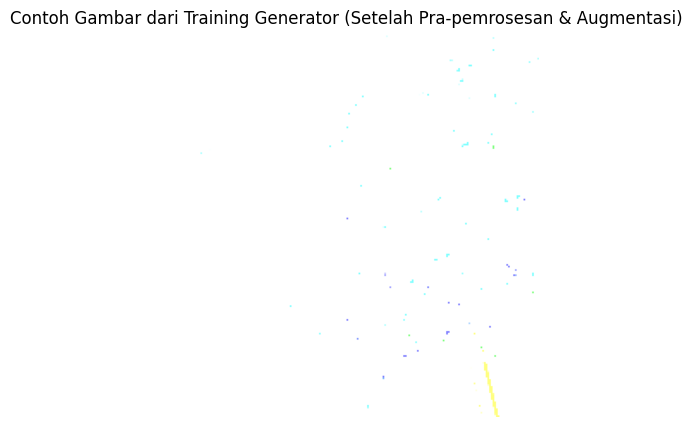

In [18]:
# Tampilkan satu gambar dari batch setelah pra-pemrosesan (perlu di-denormalize untuk visualisasi)
plt.figure(figsize=(5,5))
# Denormalisasi sederhana untuk visualisasi (jika [-1,1] -> [0,1])
img_to_show = (sample_batch_images[10] + 1.0) / 2.0
plt.imshow(img_to_show)
plt.title("Contoh Gambar dari Training Generator (Setelah Pra-pemrosesan & Augmentasi)")
plt.axis('off')
plt.show()

In [15]:
def create_mobilenet_v3_model(model_type='Small', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=NUM_CLASSES, fine_tune_at=0):
    """
    Membuat model MobileNetV3 Small atau Large untuk fine-tuning.
    
    Args:
        model_type (str): 'Small' atau 'Large'.
        input_shape (tuple): Ukuran input gambar.
        num_classes (int): Jumlah kelas output.
        fine_tune_at (int): Jumlah layer dari base model yang akan di-unfreeze.
                            Jika 0, seluruh base model di-unfreeze.
                            Jika > 0, maka `fine_tune_at` layer terakhir dari base model di-unfreeze.
                            Jika None, base model di-freeze.
    """
    if model_type == 'Small':
        base_model = MobileNetV3Small(input_shape=input_shape,
                                      include_top=False, # Tanpa classifier head bawaan
                                      weights='imagenet')
    elif model_type == 'Large':
        base_model = MobileNetV3Large(input_shape=input_shape,
                                      include_top=False,
                                      weights='imagenet')
    else:
        raise ValueError("model_type harus 'Small' atau 'Large'")

    # Freeze atau Unfreeze base model layers
    if fine_tune_at is None: # Freeze seluruh base model
        base_model.trainable = False
        print(f"Base model ({model_type}) seluruhnya di-freeze.")
    elif fine_tune_at == 0: # Unfreeze seluruh base model (fine-tune all)
        base_model.trainable = True
        print(f"Base model ({model_type}) seluruhnya di-unfreeze untuk fine-tuning.")
    else: # Unfreeze sebagian layer terakhir
        base_model.trainable = True
        # Freeze semua layer sampai `fine_tune_at`
        for layer in base_model.layers[:-fine_tune_at]:
            layer.trainable = False
        print(f"Base model ({model_type}): {fine_tune_at} layer terakhir di-unfreeze untuk fine-tuning.")
        
    # Tambahkan classifier head kustom
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Anda bisa menambahkan Dense layer tambahan di sini jika perlu
    # x = Dense(256, activation='relu')(x) 
    # x = Dropout(0.5)(x) 
    # Sesuai arsitektur MobileNetV3 yang efisien, seringkali GAP langsung ke output Dense
    
    # Lapisan output
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [16]:
# Parameter fine-tuning
# Untuk MobileNetV3Small, jumlah layer bisa dicek dengan `len(mobilenet_small_test.layers)`
# Misal, jika ingin unfreeze 20 layer terakhir: fine_tune_at_small = 20
# Jika ingin unfreeze semua: fine_tune_at_small = 0
# Jika ingin freeze semua (hanya latih head): fine_tune_at_small = None

# Inisialisasi model (akan dikompilasi di tahap training)
print("Membuat model MobileNetV3 Small...")
# Coba unfreeze beberapa layer terakhir atau semua, misal 10 layer terakhir
# Anda perlu cek jumlah layer sebenarnya di `base_model.layers` untuk `fine_tune_at` yang pas
# Atau set `fine_tune_at=0` untuk unfreeze semua lapisan base model.
# Atau `fine_tune_at=None` untuk freeze semua lapisan base model (hanya melatih head).
mobilenet_small_model = create_mobilenet_v3_model(model_type='Small', fine_tune_at=None) # Mulai dengan freeze base
mobilenet_small_model.summary()

print("\nMembuat model MobileNetV3 Large...")
mobilenet_large_model = create_mobilenet_v3_model(model_type='Large', fine_tune_at=None) # Mulai dengan freeze base
mobilenet_large_model.summary()

Membuat model MobileNetV3 Small...


I0000 00:00:1748093015.747361   10139 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Base model (Small) seluruhnya di-freeze.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 942,582 (3.60 MB)

 Trainable params: 3,462 (13.52 KB)

 Non-trainable params: 939,120 (3.58 MB)


Membuat model MobileNetV3 Large...
Base model (Large) seluruhnya di-freeze.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_18[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_18[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_15[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 5,766 (22.52 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [17]:
EPOCHS = 50 # Jumlah epoch bisa disesuaikan, EarlyStopping akan membantu
LEARNING_RATE = 0.001 # Learning rate awal
# Callbacks
def get_callbacks(model_name):
    return [
        ModelCheckpoint(f'{model_name}_best.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True), # Meningkatkan patience
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1) # Mengurangi LR jika val_loss stagnan
    ]

In [35]:
# --- Pelatihan MobileNetV3 Small ---
print("\nMelatih MobileNetV3 Small...")
optimizer_small = Adam(learning_rate=LEARNING_RATE)
mobilenet_small_model.compile(optimizer=optimizer_small,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Jika base model di-freeze (fine_tune_at=None):
# Latih dulu head classifier
history_small_head = mobilenet_small_model.fit(
    train_generator,
    epochs=max(EPOCHS // 2, 15), # Latih head untuk beberapa epoch
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_small_head'),
)

# Setelah head terlatih, kita bisa unfreeze beberapa layer base model (atau semua)
# dan melanjutkan fine-tuning dengan learning rate yang lebih kecil.
print("\nMelanjutkan fine-tuning MobileNetV3 Small (unfreezing base model)...")
mobilenet_small_model.load_weights('mobilenet_v3_small_head_best.keras') # Load bobot terbaik dari pelatihan head

# Unfreeze base model (misal semua lapisan)
for layer in mobilenet_small_model.layers: # Cek nama base model jika berbeda
    if "mobilenet_v3_small" in layer.name: # Asumsi nama base model mengandung 'mobilenet_v3_small'
        layer.trainable = True
    else:
        layer.trainable = True # Pastikan head tetap trainable

# Atau jika Anda menggunakan fungsi create_model dengan fine_tune_at:
# mobilenet_small_model = create_mobilenet_v3_model(model_type='Small', fine_tune_at=0) # Unfreeze semua
# mobilenet_small_model.load_weights('mobilenet_v3_small_head_best.keras') # Mungkin perlu by_name=True jika arsitektur sedikit berubah

optimizer_small_finetune = Adam(learning_rate=LEARNING_RATE / 10) # Gunakan LR lebih kecil untuk fine-tuning
mobilenet_small_model.compile(optimizer=optimizer_small_finetune,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
mobilenet_small_model.summary() # Lihat status trainable layers

history_small_finetune = mobilenet_small_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_small_finetune'),
    initial_epoch=history_small_head.epoch[-1] +1 , # Lanjutkan epoch
)


Melatih MobileNetV3 Small...
Epoch 1/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7085 - loss: 0.8283
Epoch 1: val_accuracy improved from -inf to 0.87518, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 77s 184ms/step - accuracy: 0.7087 - loss: 0.8277 - val_accuracy: 0.8752 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 2/25
387/395 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8637 - loss: 0.3854
Epoch 2: val_accuracy improved from 0.87518 to 0.88017, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 152ms/step - accuracy: 0.8638 - loss: 0.3850 - val_accuracy: 0.8802 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8847 - loss: 0.3233
Epoch 3: val_accuracy improved from 0.88017 to 0.88873, saving model to mobilenet_v3_small_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 149ms/step - accuracy: 0.8847 - loss: 0.3233 - val_accuracy: 0.8887

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 942,582 (3.60 MB)

 Trainable params: 930,470 (3.55 MB)

 Non-trainable params: 12,112 (47.31 KB)

Epoch 26/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8360 - loss: 0.4588
Epoch 26: val_accuracy improved from -inf to 0.88445, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 206ms/step - accuracy: 0.8361 - loss: 0.4585 - val_accuracy: 0.8845 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 27/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9004 - loss: 0.2865
Epoch 27: val_accuracy improved from 0.88445 to 0.89943, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - accuracy: 0.9004 - loss: 0.2864 - val_accuracy: 0.8994 - val_loss: 0.2841 - learning_rate: 1.0000e-04
Epoch 28/50
393/395 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9131 - loss: 0.2383
Epoch 28: val_accuracy improved from 0.89943 to 0.91013, saving model to mobilenet_v3_small_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - accuracy: 0.9131 - loss: 0.2384 - val_accuracy: 0.9101 - 

In [18]:
# --- Pelatihan MobileNetV3 Large ---
print("\nMelatih MobileNetV3 Large...")
optimizer_large = Adam(learning_rate=LEARNING_RATE)
mobilenet_large_model.compile(optimizer=optimizer_large,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Latih dulu head classifier
history_large_head = mobilenet_large_model.fit(
    train_generator,
    epochs=max(EPOCHS // 2, 15),
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_large_head'),
)

print("\nMelanjutkan fine-tuning MobileNetV3 Large (unfreezing base model)...")
mobilenet_large_model.load_weights('mobilenet_v3_large_head_best.keras')

for layer in mobilenet_large_model.layers:
    if "mobilenet_v3_large" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = True

optimizer_large_finetune = Adam(learning_rate=LEARNING_RATE / 10)
mobilenet_large_model.compile(optimizer=optimizer_large_finetune,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
mobilenet_large_model.summary()

history_large_finetune = mobilenet_large_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=get_callbacks('mobilenet_v3_large_finetune'),
    initial_epoch=history_large_head.epoch[-1] + 1,
)


Melatih MobileNetV3 Large...


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1748093020.652473   10281 service.cc:152] XLA service 0x7fe470013fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748093020.652534   10281 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-05-24 20:23:40.739285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748093021.410011   10281 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/395 ━━━━━━━━━━━━━━━━━━━━ 49:30 8s/step - accuracy: 0.0938 - loss: 2.6312

I0000 00:00:1748093025.775802   10281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7281 - loss: 0.7409
Epoch 1: val_accuracy improved from -inf to 0.89372, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 80s 184ms/step - accuracy: 0.7284 - loss: 0.7402 - val_accuracy: 0.8937 - val_loss: 0.2957 - learning_rate: 0.0010
Epoch 2/25
392/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8955 - loss: 0.2912
Epoch 2: val_accuracy improved from 0.89372 to 0.90014, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.8955 - loss: 0.2911 - val_accuracy: 0.9001 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 3/25
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9057 - loss: 0.2589
Epoch 3: val_accuracy improved from 0.90014 to 0.90656, saving model to mobilenet_v3_large_head_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.9057 - loss: 0.2589 - val_accuracy: 0.9066 - val_loss: 0.2798 - learning_rate: 0.00

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_18[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_18[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_15[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 2,977,718 (11.36 MB)

 Non-trainable params: 24,400 (95.31 KB)

Epoch 15/50


2025-05-24 20:38:07.188095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:07.371255: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:08.773978: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:38:08.981665: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


351/395 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8486 - loss: 0.4127

2025-05-24 20:39:13.847000: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:14.037894: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:15.254587: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 20:39:15.461388: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8525 - loss: 0.4023
Epoch 15: val_accuracy improved from -inf to 0.90514, saving model to mobilenet_v3_large_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 112s 207ms/step - accuracy: 0.8526 - loss: 0.4021 - val_accuracy: 0.9051 - val_loss: 0.3018 - learning_rate: 1.0000e-04
Epoch 16/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9244 - loss: 0.2112
Epoch 16: val_accuracy did not improve from 0.90514
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 151ms/step - accuracy: 0.9244 - loss: 0.2112 - val_accuracy: 0.8966 - val_loss: 0.2963 - learning_rate: 1.0000e-04
Epoch 17/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9436 - loss: 0.1649
Epoch 17: val_accuracy improved from 0.90514 to 0.91726, saving model to mobilenet_v3_large_finetune_best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 64s 161ms/step - accuracy: 0.9436 - loss: 0.1649 - val_accuracy: 0.9173 - val_loss: 0.2429 - learning_rate: 1.0000e-04
Epoch 18/50
395/395 ━━━━━━━

In [33]:
# Fungsi untuk plot dan simpan history pelatihan
def plot_training_history(history_head, history_finetune, model_name):
    # Gabungkan history jika ada tahap head dan fine-tune
    acc = history_head.history['accuracy']
    val_acc = history_head.history['val_accuracy']
    loss = history_head.history['loss']
    val_loss = history_head.history['val_loss']

    if history_finetune:
        acc.extend(history_finetune.history['accuracy'])
        val_acc.extend(history_finetune.history['val_accuracy'])
        loss.extend(history_finetune.history['loss'])
        val_loss.extend(history_finetune.history['val_loss'])
        
    epochs_range_head = range(len(history_head.history['accuracy']))
    total_epochs = len(acc)
    epochs_range_total = range(total_epochs)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range_total, acc, label='Training Accuracy')
    plt.plot(epochs_range_total, val_acc, label='Validation Accuracy')
    if history_finetune:
        plt.axvline(len(epochs_range_head) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy - {model_name}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range_total, loss, label='Training Loss')
    plt.plot(epochs_range_total, val_loss, label='Validation Loss')
    if history_finetune:
        plt.axvline(len(epochs_range_head) - 1, color='gray', linestyle='--', label='Start Fine-tuning')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss - {model_name}')

    # Buat folder jika belum ada
    save_dir = f"results/graph/finetune"
    os.makedirs(save_dir, exist_ok=True)

    # Simpan plot sebagai PNG
    save_path = os.path.join(save_dir, f"{model_name}.png")
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Plot disimpan di: {save_path}")
    
    plt.close()

In [36]:
print("\nPlotting hasil pelatihan MobileNetV3 Small:")
plot_training_history(history_small_head, history_small_finetune, "MobileNetV3 Small")


Plotting hasil pelatihan MobileNetV3 Small:
Plot disimpan di: results/graph/finetune/MobileNetV3 Small.png


In [34]:
plot_training_history(history_large_head, history_large_finetune, "MobileNetV3_Large")

Plot disimpan di: results/graph/finetune/MobileNetV3_Large.png


In [3]:
# Load model terbaik yang disimpan
print("Memuat model terbaik MobileNetV3 Small...")
best_small_model = tf.keras.models.load_model('results/model/finetune/mobilenet_v3_small_finetune_best.keras')

print("Memuat model terbaik MobileNetV3 Large...")
best_large_model = tf.keras.models.load_model('results/model/finetune/mobilenet_v3_large_finetune_best.keras')

# Fungsi evaluasi umum
def evaluate_model(model, model_name):
    print(f"\n--- Mengevaluasi {model_name} ---")
    # Evaluasi pada test set
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss ({model_name}): {loss:.4f}")
    print(f"Test Accuracy ({model_name}): {accuracy:.4f}")

    # Prediksi pada test set
    y_pred_proba = model.predict(test_generator)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_generator.classes
    
    class_labels = list(test_generator.class_indices.keys())

    # Laporan Klasifikasi (Precision, Recall, F1-score)
    print(f"\nLaporan Klasifikasi untuk {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return y_true, y_pred_proba, class_labels

Memuat model terbaik MobileNetV3 Small...


I0000 00:00:1748139684.842094    3338 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4540 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Memuat model terbaik MobileNetV3 Large...



--- Mengevaluasi MobileNetV3 Small ---


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748139720.540904    3845 service.cc:152] XLA service 0x7f84f4003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748139720.540939    3845 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-05-25 09:22:00.579318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748139720.822977    3845 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/94 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9410 - loss: 0.2535

I0000 00:00:1748139724.720524    3845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9316 - loss: 0.2188
Test Loss (MobileNetV3 Small): 0.2106
Test Accuracy (MobileNetV3 Small): 0.9293
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step

Laporan Klasifikasi untuk MobileNetV3 Small:
              precision    recall  f1-score   support

   buildings       0.92      0.93      0.93       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.87      0.88       553
    mountain       0.88      0.90      0.89       525
         sea       0.95      0.95      0.95       510
      street       0.94      0.94      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



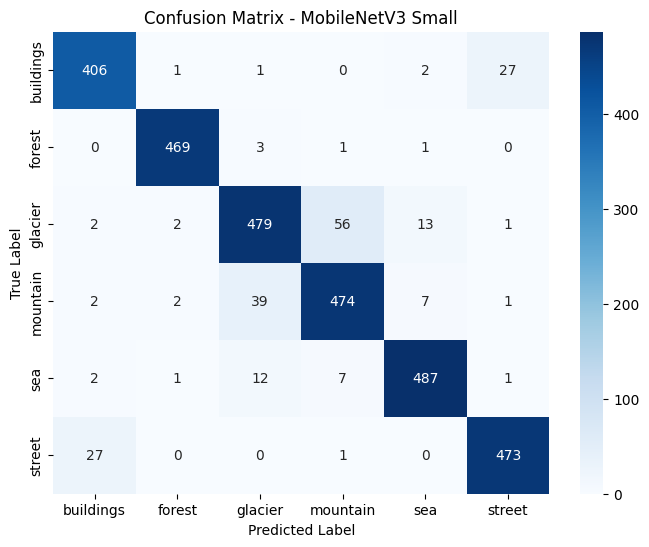


--- Mengevaluasi MobileNetV3 Large ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9441 - loss: 0.2145
Test Loss (MobileNetV3 Large): 0.2376
Test Accuracy (MobileNetV3 Large): 0.9363
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step

Laporan Klasifikasi untuk MobileNetV3 Large:
              precision    recall  f1-score   support

   buildings       0.92      0.95      0.94       437
      forest       0.98      0.99      0.99       474
     glacier       0.92      0.88      0.90       553
    mountain       0.90      0.89      0.90       525
         sea       0.95      0.98      0.96       510
      street       0.95      0.94      0.94       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



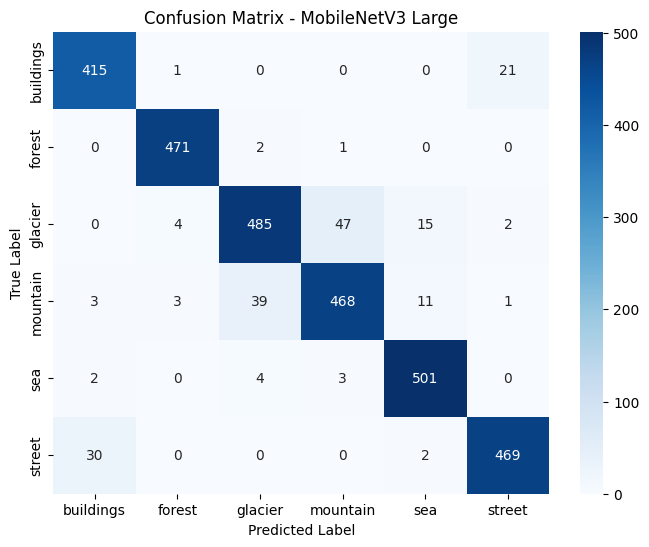

In [19]:
# Evaluasi kedua model
y_true_small, y_pred_proba_small, class_labels_small = evaluate_model(best_small_model, "MobileNetV3 Small")
y_true_large, y_pred_proba_large, class_labels_large = evaluate_model(best_large_model, "MobileNetV3 Large")

In [20]:
# --- Implementasi Grad-CAM ---
# Referensi: https://keras.io/examples/vision/grad_cam/
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # (1, height, width, channels)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Buat model yang memetakan input image ke aktivasi
    # dari layer konvolusi terakhir serta prediksi output
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Hitung gradien dari kelas prediksi teratas (atau kelas yang diberikan)
    # sehubungan dengan aktivasi layer konvolusi terakhir
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Ini adalah gradien dari output neuron (kelas prediksi teratas atau yang dipilih)
    # sehubungan dengan output feature map dari layer konvolusi terakhir
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Ini adalah vektor di mana setiap entri adalah intensitas gradien rata-rata
    # untuk saluran feature map tertentu
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Kita kalikan setiap saluran dalam array feature map
    # dengan "seberapa penting saluran ini" sehubungan dengan kelas prediksi teratas
    # lalu jumlahkan semua saluran untuk mendapatkan heatmap dari aktivasi kelas
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Untuk visualisasi, kita juga akan menormalisasi heatmap antara 0 dan 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Muat gambar asli
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Ubah ukuran heatmap ke ukuran gambar asli
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Ubah heatmap menjadi RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Terapkan heatmap pada gambar asli
    # Pastikan img adalah uint8
    superimposed_img = heatmap * alpha + img.astype(np.uint8) * (1-alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)


    plt.imshow(superimposed_img)
    plt.axis('off')

In [40]:
# Tentukan nama layer konvolusi terakhir (perlu dicek dari model.summary())
# Untuk MobileNetV3Small, biasanya sesuatu seperti 'expanded_conv_10/project/BatchNorm' atau 'Conv_1' jika dekat akhir.
# Anda perlu mencari layer konvolusi *sebelum* GlobalAveragePooling.
# Mari kita coba inspect nama layer untuk salah satu model
print("\nInspeksi layer untuk Grad-CAM (MobileNetV3 Small):")
for layer in best_small_model.layers:
    print(layer.name)
    if 'conv' in layer.name.lower() and 'expanded' in layer.name.lower(): # Cari kandidat
        last_conv_layer_name_small_candidate = layer.name


Inspeksi layer untuk Grad-CAM (MobileNetV3 Small):
input_layer
rescaling
conv
conv_bn
activation
expanded_conv_depthwise_pad
expanded_conv_depthwise
expanded_conv_depthwise_bn
re_lu
expanded_conv_squeeze_excite_avg_pool
expanded_conv_squeeze_excite_conv
expanded_conv_squeeze_excite_relu
expanded_conv_squeeze_excite_conv_1
re_lu_1
expanded_conv_squeeze_excite_mul
expanded_conv_project
expanded_conv_project_bn
expanded_conv_1_expand
expanded_conv_1_expand_bn
re_lu_2
expanded_conv_1_depthwise_pad
expanded_conv_1_depthwise
expanded_conv_1_depthwise_bn
re_lu_3
expanded_conv_1_project
expanded_conv_1_project_bn
expanded_conv_2_expand
expanded_conv_2_expand_bn
re_lu_4
expanded_conv_2_depthwise
expanded_conv_2_depthwise_bn
re_lu_5
expanded_conv_2_project
expanded_conv_2_project_bn
expanded_conv_2_add
expanded_conv_3_expand
expanded_conv_3_expand_bn
activation_1
expanded_conv_3_depthwise_pad
expanded_conv_3_depthwise
expanded_conv_3_depthwise_bn
activation_2
expanded_conv_3_squeeze_excite_avg_

In [21]:
# Biasanya layer sebelum GlobalAveragePooling2D adalah kandidat yang baik
# Atau, cari layer yang memiliki output feature map 4D (batch, height, width, channels)
# Misalnya, untuk MobileNetV3Small, bisa jadi 'expanded_conv_10/expand_activation' atau layer konvolusi terakhir sebelum GAP.
# Untuk MobileNetV3Large, bisa jadi 'expanded_conv_15/expand_activation' atau nama serupa.
# Anda HARUS memverifikasi ini dari `model.summary()`!
# Misalkan setelah verifikasi, namanya adalah:
# last_conv_layer_name_small = 'expanded_conv_10/project/BatchNorm' # INI HANYA CONTOH, VERIFIKASI!
# last_conv_layer_name_large = 'expanded_conv_15/project/BatchNorm' # INI HANYA CONTOH, VERIFIKASI!

# Untuk mendapatkan nama layer konvolusi terakhir secara programatik (lebih aman):
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4 and isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D, tf.keras.layers.SeparableConv2D)):
            # Juga pastikan itu bukan bagian dari head kustom jika head-nya kompleks
            # Untuk arsitektur standar MobileNet, ini biasanya OK
            if 'predictions' not in layer.name.lower() and 'dense' not in layer.name.lower() and 'global' not in layer.name.lower():
                 print(f"Ditemukan kandidat layer konvolusi terakhir: {layer.name}")
                 return layer.name
    # Fallback jika tidak ketemu otomatis, perlu set manual
    print("Tidak dapat menemukan nama layer konvolusi terakhir secara otomatis. Silakan set manual.")
    if 'small' in model.name.lower():
        return 'expanded_conv_10/project/BatchNorm' # Ganti dengan nama layer yang benar dari summary
    else: # large
        return 'expanded_conv_15/project/BatchNorm' # Ganti dengan nama layer yang benar dari summary


last_conv_layer_name_small = "activation_17"
last_conv_layer_name_large = "activation_37"

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Menampilkan Grad-CAM untuk MobileNetV3 Small (activation_17):


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


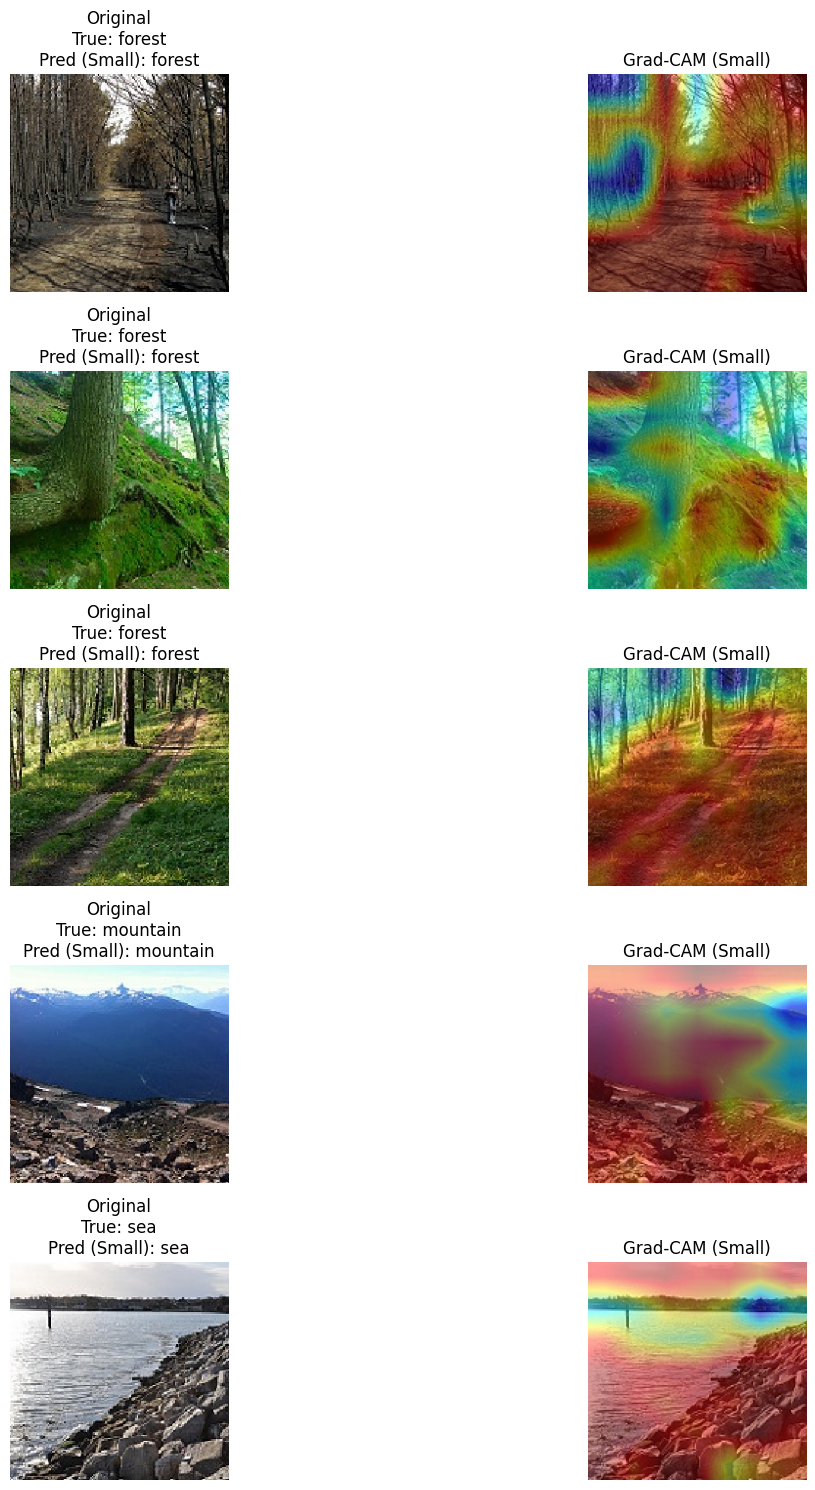


Menampilkan Grad-CAM untuk MobileNetV3 Large (activation_37):


/home/abiyamf/anaconda3/envs/PCDL_env/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


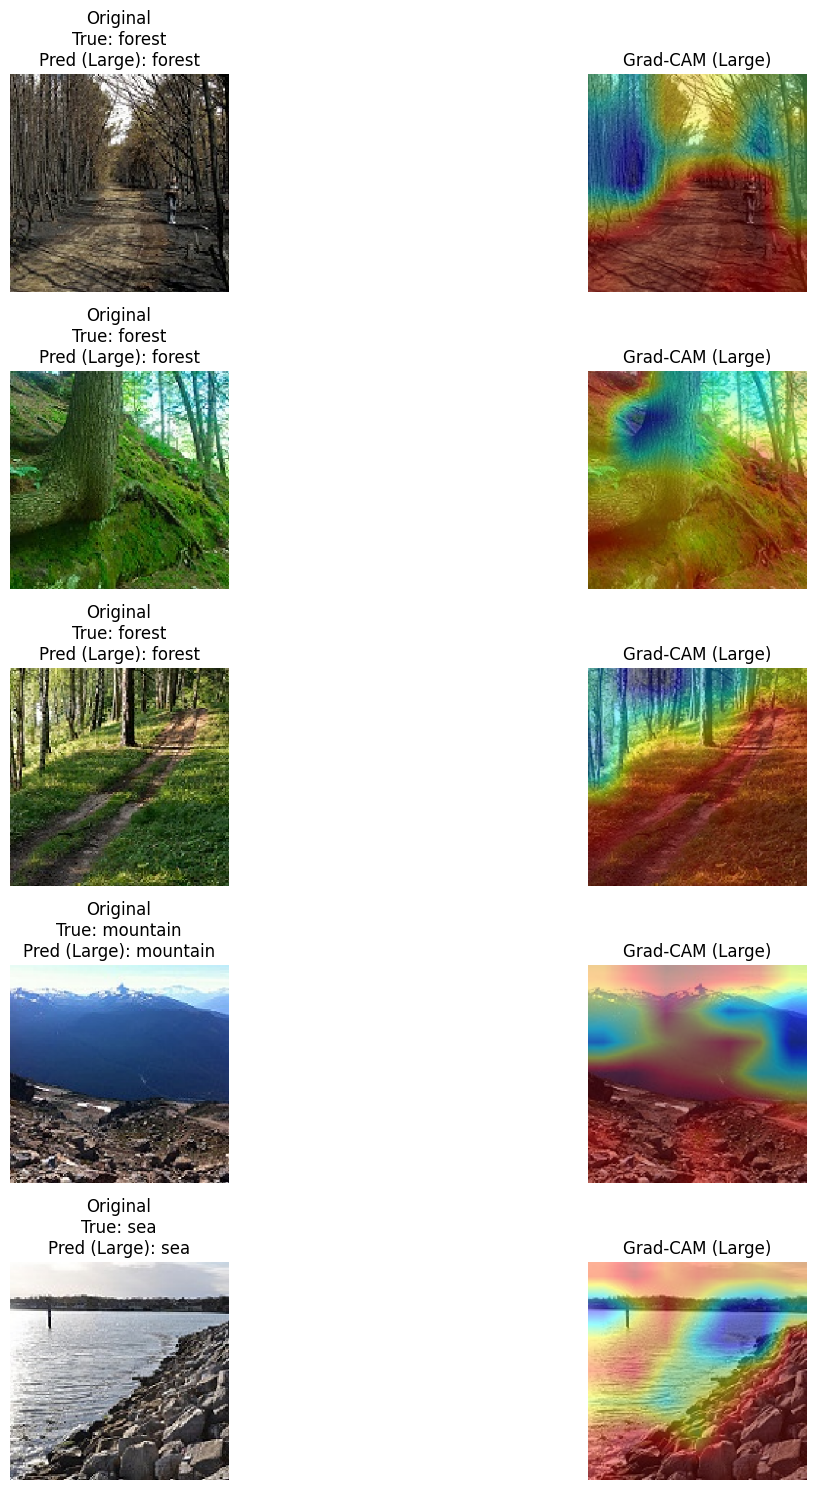


Analisis Kesalahan (Contoh):
Jumlah kesalahan (Small): 212 dari 3000
Contoh beberapa gambar yang salah diklasifikasikan oleh MobileNetV3 Small:


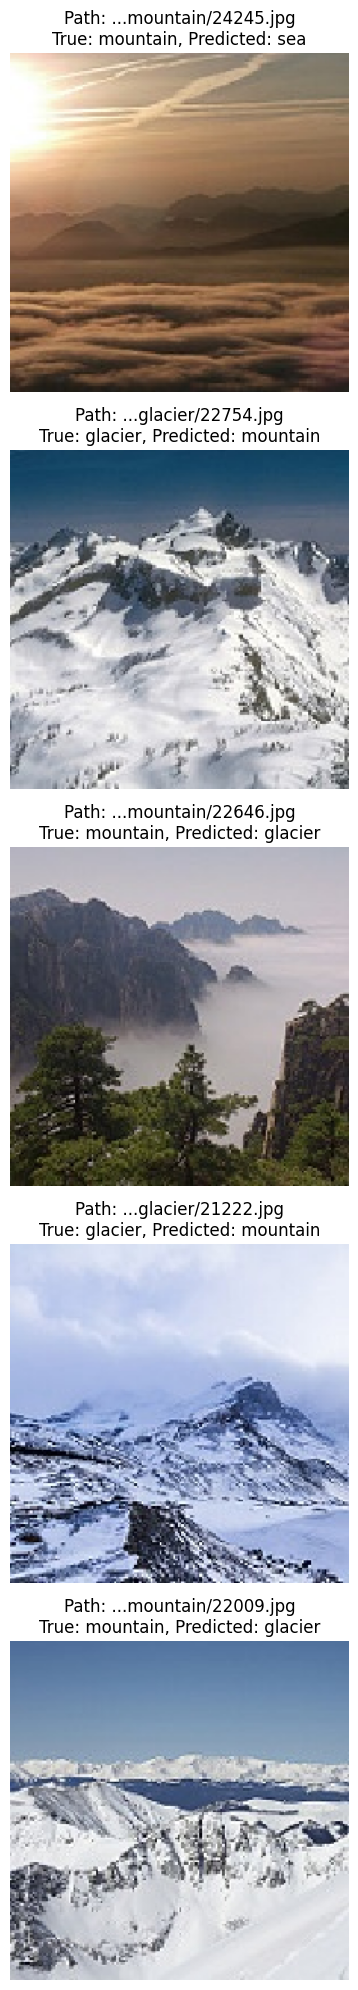


Tahap 5 Selesai.


In [22]:
# Ambil beberapa gambar dari test set untuk Grad-CAM
num_gradcam_samples = 5
test_image_paths = []
test_image_labels_true = []
test_image_pred_labels_small = []
test_image_pred_labels_large = []

# Dapatkan path file dari test_generator (agak tricky, tapi bisa)
# Atau lebih mudah, ambil saja beberapa gambar acak dari folder test
sample_indices = np.random.choice(len(test_generator.filenames), num_gradcam_samples, replace=False)

for i in sample_indices:
    img_path = os.path.join(TEST_DIR, test_generator.filenames[i])
    test_image_paths.append(img_path)
    test_image_labels_true.append(test_generator.classes[i]) # label true
    
    # Prediksi untuk gambar ini
    img_arr_processed = mobilenet_v3_preprocess_input(get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT)))
    
    pred_small_proba = best_small_model.predict(img_arr_processed)
    test_image_pred_labels_small.append(np.argmax(pred_small_proba[0]))
    
    pred_large_proba = best_large_model.predict(img_arr_processed)
    test_image_pred_labels_large.append(np.argmax(pred_large_proba[0]))


print(f"\nMenampilkan Grad-CAM untuk MobileNetV3 Small ({last_conv_layer_name_small}):")
plt.figure(figsize=(15, 3 * num_gradcam_samples))
for i, img_path in enumerate(test_image_paths):
    img_array_original = get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT)) # Untuk model
    img_array_processed = mobilenet_v3_preprocess_input(np.copy(img_array_original)) # Sudah diproses untuk model

    heatmap_small = make_gradcam_heatmap(img_array_processed, best_small_model, last_conv_layer_name_small, pred_index=test_image_pred_labels_small[i])
    
    plt.subplot(num_gradcam_samples, 2, 2 * i + 1)
    original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(original_img)
    true_label_name = class_labels_small[test_image_labels_true[i]]
    pred_label_name_small = class_labels_small[test_image_pred_labels_small[i]]
    plt.title(f"Original\nTrue: {true_label_name}\nPred (Small): {pred_label_name_small}")
    plt.axis('off')

    plt.subplot(num_gradcam_samples, 2, 2 * i + 2)
    display_gradcam(img_path, heatmap_small)
    plt.title(f"Grad-CAM (Small)")
    plt.axis('off')
plt.tight_layout()
plt.show()


print(f"\nMenampilkan Grad-CAM untuk MobileNetV3 Large ({last_conv_layer_name_large}):")
plt.figure(figsize=(15, 3 * num_gradcam_samples))
for i, img_path in enumerate(test_image_paths):
    img_array_original = get_img_array(img_path, size=(IMG_WIDTH, IMG_HEIGHT)) # Untuk model
    img_array_processed = mobilenet_v3_preprocess_input(np.copy(img_array_original)) # Sudah diproses untuk model

    heatmap_large = make_gradcam_heatmap(img_array_processed, best_large_model, last_conv_layer_name_large, pred_index=test_image_pred_labels_large[i])
    
    plt.subplot(num_gradcam_samples, 2, 2 * i + 1)
    original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(original_img)
    true_label_name = class_labels_large[test_image_labels_true[i]]
    pred_label_name_large = class_labels_large[test_image_pred_labels_large[i]]
    plt.title(f"Original\nTrue: {true_label_name}\nPred (Large): {pred_label_name_large}")
    plt.axis('off')

    plt.subplot(num_gradcam_samples, 2, 2 * i + 2)
    display_gradcam(img_path, heatmap_large)
    plt.title(f"Grad-CAM (Large)")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nAnalisis Kesalahan (Contoh):")
# Anda bisa melihat gambar mana yang sering salah klasifikasi dari confusion matrix
# atau dengan membandingkan y_true dan y_pred.
# Misalnya, untuk MobileNetV3 Small:
errors_small_indices = np.where(y_pred_proba_small.argmax(axis=1) != y_true_small)[0]
print(f"Jumlah kesalahan (Small): {len(errors_small_indices)} dari {len(y_true_small)}")

if len(errors_small_indices) > 0:
    print("Contoh beberapa gambar yang salah diklasifikasikan oleh MobileNetV3 Small:")
    num_error_samples_to_show = min(5, len(errors_small_indices))
    random_error_indices = np.random.choice(errors_small_indices, num_error_samples_to_show, replace=False)
    
    plt.figure(figsize=(15, 4 * num_error_samples_to_show))
    for i, error_idx in enumerate(random_error_indices):
        img_path = os.path.join(TEST_DIR, test_generator.filenames[error_idx])
        original_img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        
        true_label_name = class_labels_small[y_true_small[error_idx]]
        pred_label_name = class_labels_small[y_pred_proba_small.argmax(axis=1)[error_idx]]
        
        plt.subplot(num_error_samples_to_show, 1, i + 1)
        plt.imshow(original_img)
        plt.title(f"Path: ...{test_generator.filenames[error_idx][-30:]}\nTrue: {true_label_name}, Predicted: {pred_label_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nTahap 5 Selesai.")